In [45]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.models import Sequential, load_model
from keras.callbacks import CSVLogger, ReduceLROnPlateau
from keras.optimizers import adam_v2

import warnings


In [46]:
warnings.filterwarnings("ignore")
np.random.seed(120)
tf.random.set_seed(120)
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [47]:
def hav(theta):
    s = np.sin(theta / 2)
    return s * s

def get_distance_hav(lat0, lng0, lat1, lng1):
    EARTH_RADIUS = 6371
    lat0 = np.radians(lat0)
    lat1 = np.radians(lat1)
    lng0 = np.radians(lng0)
    lng1 = np.radians(lng1)

    dlng = np.fabs(lng0 - lng1)
    dlat = np.fabs(lat0 - lat1)
    h = hav(dlat) + np.cos(lat0) * np.cos(lat1) * hav(dlng)
    distance = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(h))
    return distance

def createSequence(data, window=10, maxmin=None):
    train_seq = []
    train_label = []
    m, n = maxmin
    for traj_id in set(data['mmsi']):
        data_temp = data.loc[data.mmsi == traj_id]
        first_lon = data_temp.loc[0, 'lon']
        first_lat = data_temp.loc[0, 'lat']
        end_lon = data_temp.loc[data_temp.shape[0] - 1, 'lon']
        end_lat = data_temp.loc[data_temp.shape[0] - 1, 'lat']

        data_temp = np.array(data_temp.loc[:, ['lon', 'lat', 'sog', 'cog']])
        # 标准化
        data_temp = (data_temp - n) / (m - n)

        for i in range(data_temp.shape[0] - window):
            x = []
            for j in range(i, i + window):
                x.append(list(data_temp[j, :]))
            train_seq.append(x)
            train_label.append(data_temp[i + window, :])

    train_seq = np.array(train_seq, dtype='float64')
    train_label = np.array(train_label, dtype='float64')

    return train_seq, train_label

# 多维反归一化
def FNormalizeMult(y_pre, y_true, max_min):
    [m1, n1, s1, c1], [m2, n2, s2, c2] = max_min
    y_pre[:, 0] = y_pre[:, 0] * (m1 - m2) + m2
    y_pre[:, 1] = y_pre[:, 1] * (n1 - n2) + n2
    y_pre[:, 2] = y_pre[:, 2] * (s1 - s2) + s2
    y_pre[:, 3] = y_pre[:, 3] * (c1 - c2) + c2
    y_true[:, 0] = y_true[:, 0] * (m1 - m2) + m2
    y_true[:, 1] = y_true[:, 1] * (n1 - n2) + n2
    y_true[:, 2] = y_true[:, 2] * (s1 - s2) + s2
    y_true[:, 3] = y_true[:, 3] * (c1 - c2) + c2

    # 计算距离
    y_pre = np.insert(y_pre, y_pre.shape[1],
                      get_distance_hav(y_true[:, 1], y_true[:, 0], y_pre[:, 1], y_pre[:, 0]), axis=1)

    return y_pre, y_true

In [48]:
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, GRU, Reshape, Add, Attention
from keras.optimizers import Adam
from keras.callbacks import CSVLogger, ReduceLROnPlateau
import numpy as np

def trainModel(train_X, train_Y, test_X, test_Y):
    input_layer = Input(shape=(train_X.shape[1], train_X.shape[2]))
    conv1 = Conv1D(filters=64, kernel_size=2, activation='relu', padding='same')(input_layer)
    conv2 = Conv1D(filters=64, kernel_size=2, activation='relu', padding='same')(conv1)
    max_pooling = MaxPooling1D(pool_size=2)(conv2)
    flatten = Flatten()(max_pooling)
    dense1 = Dense(100, activation='relu')(flatten)
    
    reshaped = Reshape((1, dense1.shape[1]))(dense1)


    gru1 = GRU(108, return_sequences=True)(reshaped)
#     gru1_dropout = Dropout(0.1)(gru1)  # Adding Dropout after the first GRU layer
    gru2 = GRU(108, return_sequences=True)(gru1)
    gru3 = GRU(108, return_sequences=False)(gru2)
    dense2 = Dense(50, activation='relu')(gru3)
    output_layer = Dense(train_Y.shape[1], activation='relu')(dense2)

    model = Model(inputs=input_layer, outputs=output_layer)

    # 设置优化器
    adam = Adam(learning_rate=0.01)
    model.compile(loss='mse', optimizer=adam, metrics=['acc'])

    # 保存训练过程中的日志
    log = CSVLogger(f"./CNN_GRU_log.csv", separator=",", append=True)

    # 设置自适应学习率调整策略
    reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=1, verbose=1, mode='auto', min_delta=0.001, cooldown=0, min_lr=0.001)

    # 开始模型训练
    model.fit(train_X, train_Y, epochs=50, batch_size=32, verbose=1, validation_split=0.1, callbacks=[log, reduce])

    # 在测试集上评估模型性能
    loss, acc = model.evaluate(test_X, test_Y, verbose=1)
    print('Loss : {}, Accuracy: {}'.format(loss, acc * 100))

    # 保存模型
    model.save(f"./CNN_GRU_model.h5")

    # 打印模型结构和参数统计
    model.summary()

    return model


In [49]:
# 获取数据
train = pd.read_csv("./train.csv",index_col=0)
test = pd.read_csv("./test.csv",index_col=0)
train.head()

mmsi     updateDateFormat         lon  \
0  413842492_2021-10-15 11:25:20_4_0  2021-10-16 07:41:01  120.468625   
1  413842492_2021-10-15 11:25:20_4_0  2021-10-16 07:43:01  120.466964   
2  413842492_2021-10-15 11:25:20_4_0  2021-10-16 07:45:01  120.465346   
3  413842492_2021-10-15 11:25:20_4_0  2021-10-16 07:47:01  120.463671   
4  413842492_2021-10-15 11:25:20_4_0  2021-10-16 07:49:01  120.461955   

         lat  cog  sog  
0  30.736513  264  1.7  
1  30.736357  258  1.7  
2  30.736038  258  1.8  
3  30.735686  259  1.8  
4  30.735358  261  1.9

In [50]:
# 计算归一化参数
nor = np.array(train.loc[:, ['lon', 'lat', 'sog', 'cog']])
m = nor.max(axis=0)
n = nor.min(axis=0)
maxmin = [m, n]
# 步长
windows = 10
train_seq, train_label = createSequence(train, windows, maxmin)
test_seq, test_label = createSequence(test, windows, maxmin)

In [51]:
# 训练模型
C_G_model = trainModel(train_seq, train_label,test_seq,test_label)
# C_G_model = load_model("./C_G_model.h5")

Epoch 1/50
3282/3282 [==============================] - 22s 6ms/step - loss: 0.0048 - acc: 0.8953 - val_loss: 0.0026 - val_acc: 0.9048 - lr: 0.0100
Epoch 2/50
3279/3282 [============================>.] - ETA: 0s - loss: 0.0029 - acc: 0.9228
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
3282/3282 [==============================] - 17s 5ms/step - loss: 0.0029 - acc: 0.9228 - val_loss: 0.0038 - val_acc: 0.8956 - lr: 0.0100
Epoch 3/50
3282/3282 [==============================] - 17s 5ms/step - loss: 0.0020 - acc: 0.9459 - val_loss: 0.0018 - val_acc: 0.9484 - lr: 0.0050
Epoch 4/50
3282/3282 [==============================] - 17s 5ms/step - loss: 0.0017 - acc: 0.9494 - val_loss: 0.0017 - val_acc: 0.9546 - lr: 0.0050
Epoch 5/50
3279/3282 [============================>.] - ETA: 0s - loss: 0.0017 - acc: 0.9508
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
3282/3282 [==============================] - 17s 5ms/step - loss: 0.0017 - acc: 0.

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 10, 4)]           0         
                                                                 
 conv1d_10 (Conv1D)          (None, 10, 64)            576       
                                                                 
 conv1d_11 (Conv1D)          (None, 10, 64)            8256      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 5, 64)            0         
 1D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 320)               0         
                                                                 
 dense_7 (Dense)             (None, 100)               32100     
                                                                 
 reshape_4

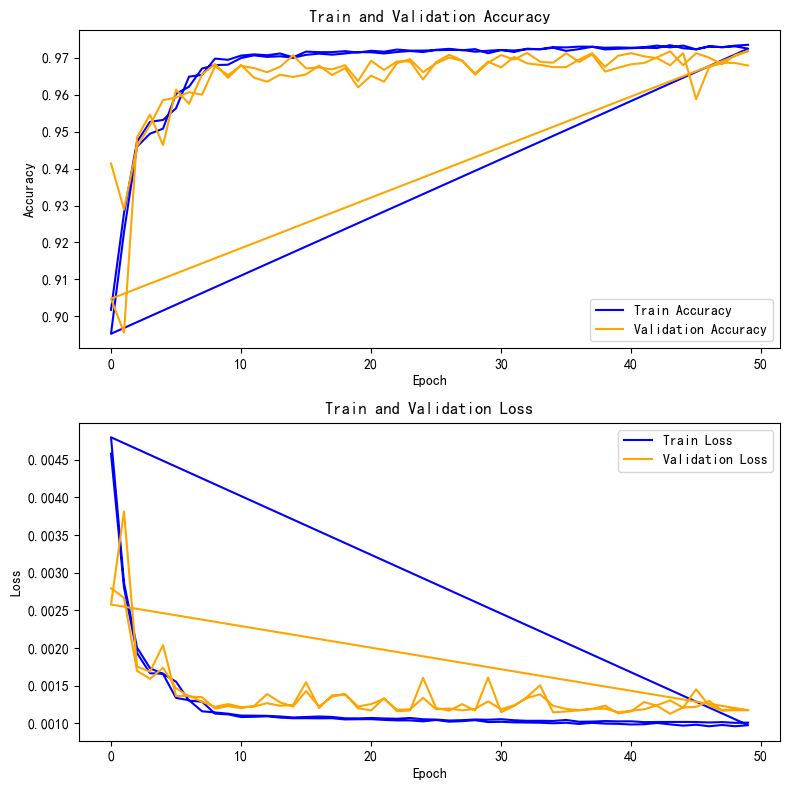

In [52]:
logs = pd.read_csv("./CNN_GRU_log.csv")


fig, ax = plt.subplots(2, 1, figsize=(8, 8))

# Plot accuracy
ax[0].plot(logs['epoch'], logs['acc'], label='Train Accuracy', color='blue')
ax[0].plot(logs['epoch'], logs['val_acc'], label='Validation Accuracy', color='orange')
ax[0].set_title('Train and Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Plot loss
ax[1].plot(logs['epoch'], logs['loss'], label='Train Loss', color='blue')
ax[1].plot(logs['epoch'], logs['val_loss'], label='Validation Loss', color='orange')
ax[1].set_title('Train and Validation Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 14ms/step
最大值: 0.11163450128159626
最小值: 0.003995564594604082
均值: 0.04195755138244433
方差: 0.0008359361192486718
标准差: 0.028912559887506878
中位数: 0.036363737379555776


NameError: name 'tbd' is not defined

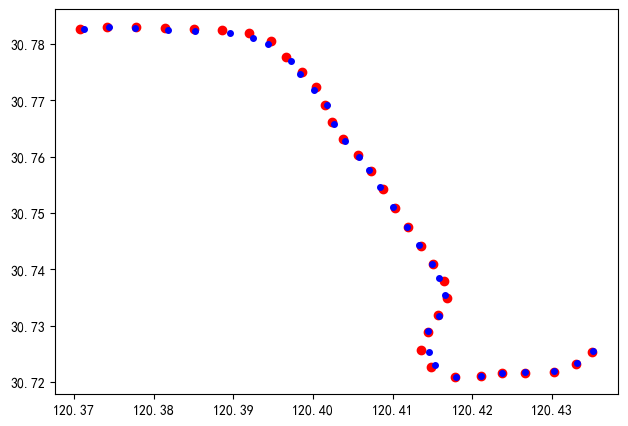

In [53]:
test_points_ids = list(set(test['mmsi']))

for ids in test_points_ids[:1]:
    y_pre = []
    test_seq, test_label = createSequence(test.loc[test.mmsi == ids], windows, maxmin)

    y_true = test_label
    for i in range(len(test_seq)):
        y_hat = C_G_model.predict(test_seq[i].reshape(1, windows, 4))
        y_pre.append(y_hat[0])
    y_pre = np.array(y_pre, dtype='float64')

    f_y_pre, f_y_true = FNormalizeMult(y_pre, y_true, maxmin)

    print(f"最大值: {max(f_y_pre[:, 4])}\n最小值: {min(f_y_pre[:, 4])}\n均值: {np.mean(f_y_pre[:, 4])}\n"
          f"方差: {np.var(f_y_pre[:, 4])}\n标准差: {np.std(f_y_pre[:, 4])}\n中位数: {np.median(f_y_pre[:, 4])}")

    # 画测试样本数据库
    plt.figure(figsize=(16, 5))
    plt.subplot(121)
    plt.plot(f_y_true[:, 0], f_y_true[:, 1], "ro", markersize=6,label='真实值')
    plt.plot(f_y_pre[:, 0], f_y_pre[:, 1], "bo",markersize=4, label='预测值')
    bounds = [min(f_y_true[:, 0])-0.02,min(f_y_true[:, 1])-0.01,max(f_y_true[:, 0])+0.02,max(f_y_true[:, 1])+0.01]
    tbd.plot_map(plt,bounds,zoom = 16,style = 3)
    plt.legend(fontsize=14)
    plt.grid()
    plt.xlabel("经度",fontsize=14)
    plt.ylabel("纬度",fontsize=14)
    plt.title("MMSI:",fontsize=17)

    meanss = np.mean(f_y_pre[:, 4])
    plt.subplot(122)
    plt.bar(range(f_y_pre.shape[0]),f_y_pre[:, 4],label='误差')
    plt.plot([0,f_y_pre.shape[0]],[meanss,meanss],'--r',label="均值")
    plt.title("预测值和真实值的误差",fontsize=17)
    plt.xlabel("船舶轨迹点",fontsize=14)
    plt.ylabel("预测误差(KM)",fontsize=14)
    plt.text(f_y_pre.shape[0]*1.01,meanss*0.96,round(meanss,4),fontsize=14,color='r')
    plt.grid()
    plt.legend(fontsize=14)

    plt.figure(figsize=(16, 6))
    plt.subplot(121)
    plt.plot(f_y_pre[:, 2], "b-", label='预测值')
    plt.plot(f_y_true[:, 2], "r-", label='真实值')
    plt.legend(fontsize=14)
    plt.title("航速预测",fontsize=17)
    plt.xlabel("船舶轨迹点",fontsize=14)
    plt.ylabel("航速/节",fontsize=14)
    plt.grid()

    plt.subplot(122)
    plt.plot(f_y_pre[:, 3], "b-", label='预测值')
    plt.plot(f_y_true[:, 3], "r-", label='真实值')
    plt.legend(fontsize=14)
    plt.title("航向预测",fontsize=17)
    plt.xlabel("船舶轨迹点",fontsize=14)
    plt.ylabel("航向/度",fontsize=14)
    plt.grid()

In [ ]:
for ids in test_points_ids[:1]:
    test_seq, test_label = createSequence(test.loc[test.mmsi == ids], windows,maxmin)

    y_pre = []
    for i in range(len(test_seq)):
        y_hat = C_G_model.predict(test_seq[i].reshape(1, windows, 4))
        y_pre.append(y_hat[0])
    y_pre = np.array(y_pre, dtype='float64')
    # 得到真实值
    _,true_lables = FNormalizeMult(y_pre,np.copy(test_label),maxmin)

    for start_id in range(3,4):
        # 单值预测
        y_pre=[]
        y_true = []
        pre_seq = test_seq[start_id]
        maxStep = min(15,test_seq.shape[0] - start_id)
        # 循环预测
        for i in range(maxStep):
            y_hat = C_G_model.predict(pre_seq.reshape(1, windows, 4))
            y_pre.append(y_hat[0])
            y_true.append(test_label[start_id+i])
            # 下一个数组
            pre_seq = np.insert(pre_seq, pre_seq.shape[0], y_pre[i], axis=0)[1:]

        y_pre = np.array(y_pre, dtype='float64')
        y_true = np.array(y_true, dtype='float64')
        f_y_pre,f_y_true = FNormalizeMult(y_pre,y_true,maxmin)

        plt.figure(figsize=(14,6))
        plt.subplot(121)
        plt.plot(f_y_pre[:, 0], f_y_pre[:, 1], "bo", label='预测值')
        plt.plot(f_y_true[:, 0], f_y_true[:, 1], "ro", label='真实值')
        plt.plot(true_lables[:start_id, 0], true_lables[:start_id, 1], "o",color='#eef200', label='历史位置')
        bounds = [min(f_y_true[:, 0])-0.01,min(f_y_true[:, 1])-0.01,max(f_y_true[:, 0])+0.01,max(f_y_true[:, 1])+0.01]
        tbd.plot_map(plt,bounds,zoom = 16,style = 3)
        plt.legend(fontsize=15)
        plt.title(f'预测步数量={maxStep},开始位置={start_id}',fontsize=17)
        plt.title(f'真实轨迹与预测轨迹',fontsize=17)
        plt.xlabel("经度",fontsize=15)
        plt.ylabel("纬度",fontsize=15)
        plt.grid()

        plt.subplot(122)
        plt.plot(np.arange(2,2*(maxStep)+1,2),f_y_pre[:,4])
        plt.xticks(np.arange(2,2*(maxStep)+1,2))
        plt.title(f'随着时间迭代的距离误差',fontsize=17)
        plt.xlabel("时间/分钟",fontsize=15)
        plt.ylabel("距离误差/千米",fontsize=15)
        plt.grid()

In [ ]:
error_list = []
for ids in test_points_ids[:1]:
    test_seq, test_label = createSequence(test.loc[test.mmsi == ids], windows, maxmin)
    # 要预测的时间
    pre_time = 30
    for start_id in range(test_seq.shape[0]-int(pre_time/2)):
        # 单值预测
        y_pre=[]
        y_true = []
        pre_seq = test_seq[start_id]
        # 循环预测
        for i in range(int(pre_time/2)):
            y_hat = C_G_model.predict(pre_seq.reshape(1, windows, 4))
            y_pre.append(y_hat[0])
            y_true.append(test_label[start_id+i])
            # 下一个数组，把预测的值作为预测序列的最后一个值，实现循环预测
            pre_seq = np.insert(pre_seq, pre_seq.shape[0], y_pre[i], axis=0)[1:]

        y_pre = np.array(y_pre, dtype='float64')
        y_true = np.array(y_true, dtype='float64')
        f_y_pre,f_y_true = FNormalizeMult(y_pre,y_true,maxmin)
        error_list.append(list(f_y_pre[:,4]))

In [ ]:
b = np.zeros([len(error_list),len(max(error_list,key = lambda x: len(x)))])
for i,j in enumerate(error_list):
    b[i][0:len(j)] = j

sums = b.sum(axis=0)
maxx = b.max(axis=0)
minx = []
means = []
for col in range(b.shape[1]):
    fzeros = b.shape[0] - list(b[:,col]).count(0.0)
    minx.append(min(list(b[:fzeros,col])))
    means.append(sums[col] / fzeros)

plt.figure(figsize=(12,6))
plt.plot(np.arange(2,2*(b.shape[1])+1,2),means,'-r',label='平均误差')
# plt.plot(np.arange(2,2*(b.shape[1])+1,2),minx,'-g',label='最小误差')
# plt.plot(np.arange(2,2*(b.shape[1])+1,2),maxx,'-y',label='最大误差')
plt.xticks(np.arange(2,2*(b.shape[1])+1,2))
plt.yticks(np.arange(0,max(maxx),0.04))
plt.xlabel("时间/分钟",fontsize=14)
plt.ylabel("距离误差/千米",fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.title("整条轨迹上随时间变化的预测距离误差",fontsize=17)

In [ ]:
print(means)